In [2]:
import torch

DATA_DIR = '../data/graph_data/'

model_type = 'dynamic' 

if model_type == 'static':
    filename = '1_hr_time_window_static_graph/dataset_all_route_single_graph.pt'
else:
    filename = '../SNA_create_graph/data/graph_data/1_hr_time_window_dynamic_graph/dataset_all_route_dynamic_graph_10_features.pt'

/home/sgupta/anaconda3/envs/pytenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from xgboost import XGBClassifier

In [4]:
dataset = torch.load(f'{filename}')

In [5]:
def get_column_wise_mean(feature_matrix):
    try:
        # Stack the arrays vertically
        stacked_arrays = np.vstack(feature_matrix)

        # Calculate the mean column-wise
        column_wise_mean = np.mean(stacked_arrays, axis=0)
    except:
        return None
    
    return column_wise_mean.reshape(1,-1)

In [6]:
len(dataset)

13525

In [7]:
import numpy as np
from tqdm import tqdm

random_forest_data = []

for i in tqdm(range(len(dataset))):
    feature_cat_0 = [dataset[i].x for j in range(len(dataset[i].y)) if dataset[i].y[j] == 0]
    feature_cat_1 = [dataset[i].x for j in range(len(dataset[i].y)) if dataset[i].y[j] == 1]
    feature_cat_2 = [dataset[i].x for j in range(len(dataset[i].y)) if dataset[i].y[j] == 2]
    feature_cat_3 = [dataset[i].x for j in range(len(dataset[i].y)) if dataset[i].y[j] == 3]

    
    feature_cat_0 = get_column_wise_mean(feature_cat_0)
    feature_cat_1 = get_column_wise_mean(feature_cat_1)
    feature_cat_2 = get_column_wise_mean(feature_cat_2)
    feature_cat_3 = get_column_wise_mean(feature_cat_3)

    # Saving it as a tuple in a list 
    if feature_cat_0 is not None:
        tup = (feature_cat_0,0)
        random_forest_data.append(tup)
    if feature_cat_1 is not None:
            tup = (feature_cat_1,1)
            random_forest_data.append(tup)
    if feature_cat_2 is not None:
            tup = (feature_cat_2,2)
            random_forest_data.append(tup)
    if feature_cat_3 is not None:
            tup = (feature_cat_3,3)
            random_forest_data.append(tup)

100%|██████████| 13525/13525 [01:08<00:00, 196.72it/s]


In [8]:
count_0 = 0
count_1 = 0 
count_2 = 0 
count_3 = 0 

for i in range(len(random_forest_data)):
    # display(random_forest_data[i])
    if random_forest_data[i][1] == 0:
        count_0+=1
    if random_forest_data[i][1] == 1:
        count_1+=1
    if random_forest_data[i][1] == 2:
        count_2+=1
    if random_forest_data[i][1] == 3:
        count_3+=1

count_0,count_1,count_2,count_3

(13378, 12898, 5387, 1889)

In [9]:
# Sanity checks
for i in range(len(random_forest_data)):
    # print(random_forest_data[i][0].shape)
    if random_forest_data[i][0].shape != (1,10):
        print(random_forest_data[i][0])
        break

In [10]:
X = []
y = []

for i in range(len(random_forest_data)):
    X.append(random_forest_data[i][0].reshape(-1))
    y.append(random_forest_data[i][1])

In [11]:
test_size = int(len(X)*0.2)
train_size = int(len(X) - test_size)

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print(len(X_train),len(X_test))

26842 6710


In [12]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train= np.array(X)[train_index]
    y_train = np.array(y)[train_index]

    X_test= np.array(X)[test_index]
    y_test = np.array(y)[test_index]

    break

### Training Random Forest Classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 500)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train,y_train)
  

RandomForestClassifier(n_estimators=500)

In [14]:
# performing predictions on the test dataset
y_pred = clf.predict(X_test)

In [15]:
from sklearn import metrics  

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.39904634182685145


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def get_CM(y_true,y_pred,title,comment,path):
    test_acc = (y_pred == y_true).sum()/len(y_true)

    print(f"Accuracy {comment}:",test_acc)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = disp.plot(ax=ax)
    # Add a title to the plot
    ax.set_title(title + " - Real Count")
    # plt.savefig(f'{path}/CM_real_55_{comment}.jpg')
    plt.show()

    # Getting the percentage CM
    cm = ((cm * 100) / (cm.sum(axis=1)[:, np.newaxis]))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    _ = disp.plot(ax=ax)
    # Add a title to the plot
    ax.set_title(title + " - Percentages")
    # plt.savefig(f'{path}/CM_percentage_55{comment}.jpg')
    plt.show()

    return test_acc

In [17]:
import pandas as pd

temp = pd.DataFrame(columns=['ytrue','ypred'])
temp.ytrue = y_test
temp.ypred = y_pred

Accuracy with 4th bin: 0.39904634182685145


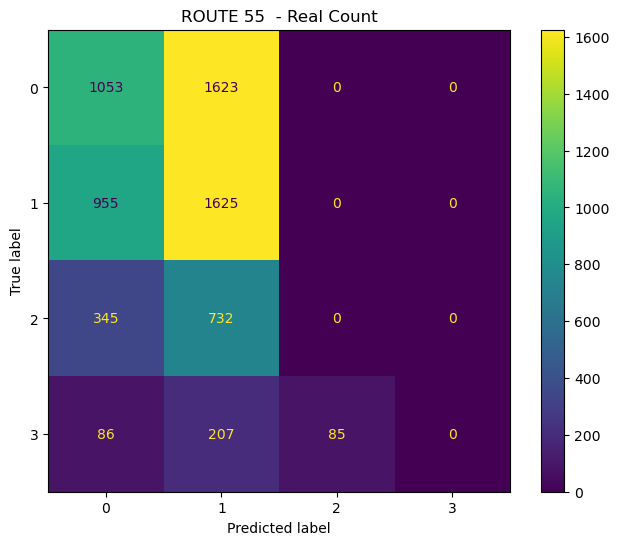

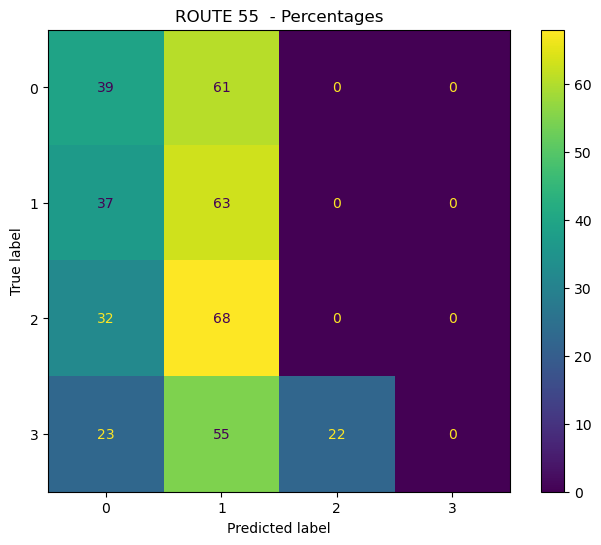

In [18]:
test_acc_w_4th = get_CM(temp.ytrue,temp.ypred,'ROUTE 55 ','with 4th bin','curr_experiment_path')
# history['test_acc_with_4th_bin'] = test_acc_w_4th


In [19]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, support = precision_recall_fscore_support(temp.ytrue,temp.ypred, average='weighted')

/home/sgupta/anaconda3/envs/pytenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
precision, recall, f1_score, support

(0.3213581616588708, 0.39904634182685145, 0.34881411882253327, None)

In [21]:
def accuracy_metric(y_true,y_pred):
        a = []
        
        for i in range(len(y_true)):
            yt = y_true[i]
            yp = y_pred[i]

            temp = 1 - (np.abs(yt-yp)/4)
            a.append(temp)
        # print(a)
        accuracy = sum(a)/len(y_true)

        return accuracy

custom_accuracy = accuracy_metric(temp.ytrue,temp.ypred)
print('Custom Accuracy Metric:',custom_accuracy)

Custom Accuracy Metric: 0.8227909402473551


### Training Multi Layer Perceptron

In [22]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=1000).fit(X_train, y_train)

# clf.predict_proba(X_test[:1])



In [23]:
y_pred = clf.predict(X_test)

In [24]:
y_pred.shape, y_test.shape

((6711,), (6711,))

In [25]:
import pandas as pd

temp = pd.DataFrame(columns=['ytrue','ypred'])
temp.ytrue = y_test
temp.ypred = y_pred

Accuracy with 4th bin: 0.400834450901505


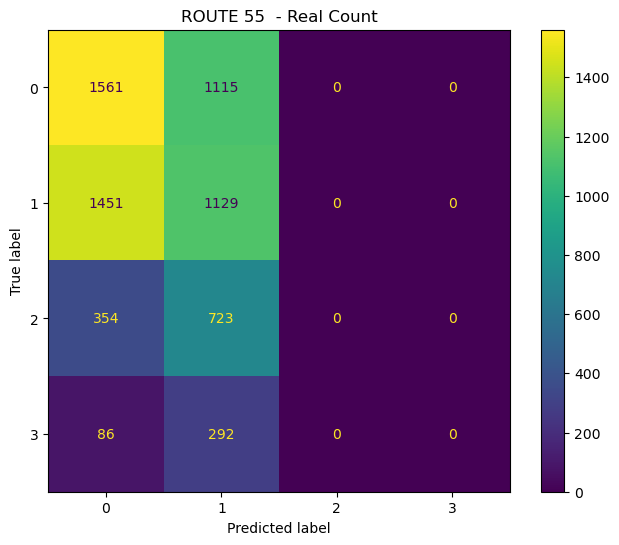

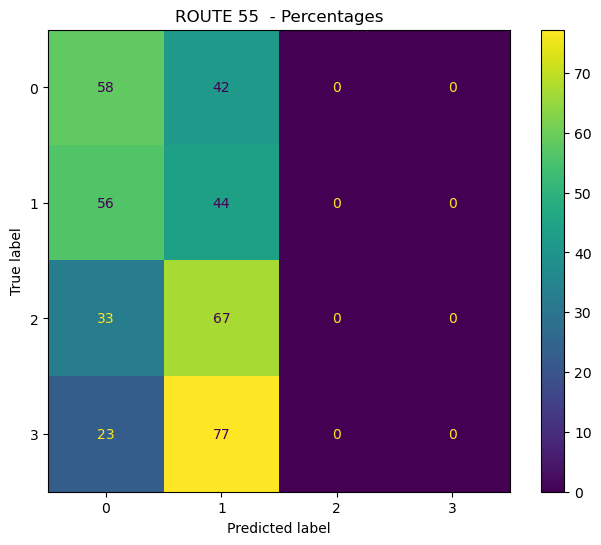

In [26]:
test_acc_w_4th = get_CM(temp.ytrue,temp.ypred,'ROUTE 55 ','with 4th bin','curr_experiment_path')
# history['test_acc_with_4th_bin'] = test_acc_w_4th


In [27]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, support = precision_recall_fscore_support(temp.ytrue,temp.ypred, average='weighted')

/home/sgupta/anaconda3/envs/pytenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
precision, recall, f1_score, support 

(0.3134955704686953, 0.400834450901505, 0.35181636316729525, None)

In [29]:
custom_accuracy = accuracy_metric(temp.ytrue,temp.ypred)
print('Custom Accuracy Metric:',custom_accuracy)

Custom Accuracy Metric: 0.8197362539114886


### XGBoost

In [32]:
model = XGBClassifier()

In [33]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [34]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
y_pred = model.predict(X_test)


In [36]:
import pandas as pd

temp = pd.DataFrame(columns=['ytrue','ypred'])
temp.ytrue = y_test
temp.ypred = y_pred

Accuracy with 4th bin: 0.39576814185665327


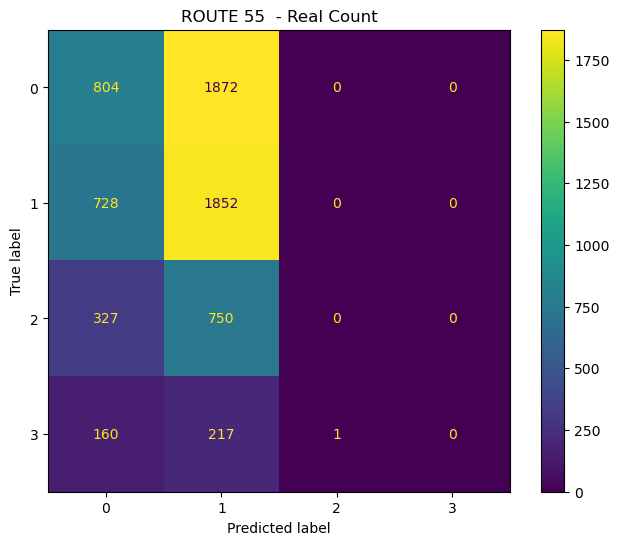

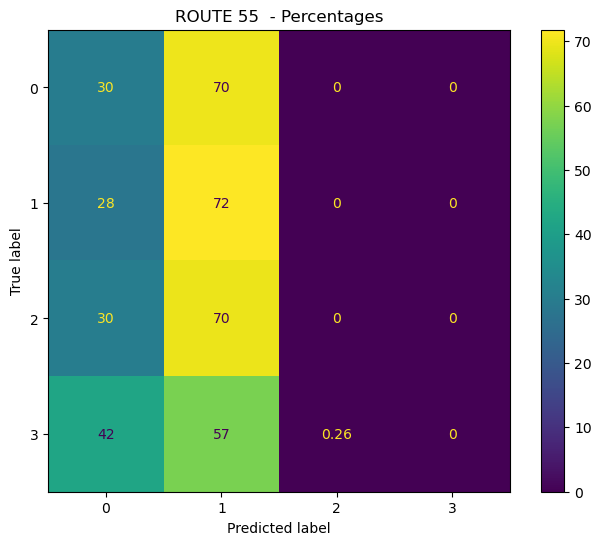

In [37]:
test_acc_w_4th = get_CM(temp.ytrue,temp.ypred,'ROUTE 55 ','with 4th bin','curr_experiment_path')
# history['test_acc_with_4th_bin'] = test_acc_w_4th


In [38]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, support = precision_recall_fscore_support(temp.ytrue,temp.ypred, average='weighted')

/home/sgupta/anaconda3/envs/pytenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
precision, recall, f1_score, support 

(0.3105660540973356, 0.39576814185665327, 0.3324116784247004, None)

In [40]:
custom_accuracy = accuracy_metric(temp.ytrue,temp.ypred)
print('Custom Accuracy Metric:',custom_accuracy)

Custom Accuracy Metric: 0.8167560721203994
